# METRICS
Calculando métricas do relatório e gerando gráficos

In [53]:
import os

import pandas as pd


def transform_binary(df, column):
    df[column] = (
        df[column]
        .replace({2: 0, 9: pd.NA})
        .astype("Int64")
    )
    return df

def transform_evolution(df):
    df["EVOLUCAO"] = (
        df["EVOLUCAO"]
        .replace({2: 1, 1: 0, 3: 0, 9: pd.NA})
        .astype("Int64")
    )
    return df

def to_datetime(df, column):
    df[column] = pd.to_datetime(df[column], format="%Y-%m-%d", errors="coerce")

def drop_columns(df):
  null_pct = df.isna().mean()
  cols_to_drop = null_pct[null_pct > 0.5].index

  df = df.drop(columns=cols_to_drop)

  df.columns = (
    df.columns
      .str.replace("\ufeff", "", regex=False)
      .str.strip()
      .str.upper()
  )

  cols_drop = ["NU_NOTIFIC", "DT_SIN_PRI", "SEM_NOT", "SEM_PRI", "ID_REGIONA", "CO_REGIONA", "ID_MUNICIP", "CO_MUN_NOT", "NU_IDADE_N", "TP_IDADE", "COD_IDADE", "ID_PAIS",
             "CO_PAIS","SG_UF", "ID_RG_RESI", "CO_RG_RESI", "ID_MN_RESI", "CO_MUN_RES", "CS_SEXO","CS_RACA", "CS_GESTANT", "CS_ESCOL_N", "CS_ZONA", "NOSOCOMIAL", "AVE_SUINO", "FEBRE", "TOSSE",
             "GARGANTA","DISPNEIA","DESC_RESP", "HISTO_VGM", "SATURACAO", "DIARREIA", "VOMITO", "OUTRO_SIN", "ANTIVIRAL", "TRAT_COV", "HOSPITAL", "SG_UF_INTE", "ID_RG_INTE",
             "CO_RG_INTE", "DT_INTERNA", "DT_NASC",
             "CO_MU_INTE", "SURTO_SG","ID_MN_INTE", "NM_UN_INTE", "RAIOX_RES","SUPORT_VEN","AMOSTRA", "TP_AMOSTRA", "DT_COLETA", "PCR_RESUL","DT_PCR","PCR_VSR","PCR_PARA1",
             "PCR_PARA2","PCR_PARA3","PCR_PARA4","PCR_ADENO","PCR_METAP","PCR_BOCA","PCR_RINO","PCR_OUTRO","CLASSI_FIN","CRITERIO","DT_ENCERRA","DT_DIGITA","PCR_SARS2",
             "DOR_ABD","FADIGA","PERD_OLFT","PERD_PALA","TOMO_RES","RES_AN","AN_SARS2","AN_VSR","AN_PARA1","AN_PARA2","AN_PARA3","AN_ADENO","AN_OUTRO","POV_CT","TEM_CPF",
             "ESTRANG","FNT_IN_COV","CO_DETEC","REINF"]
  return df.drop(columns=cols_drop, errors="ignore")

def save_csv(df, path):
  os.makedirs(os.path.dirname(path), exist_ok=True)
  df.to_csv(path, index=False)
  print(f"CSV saved in '{path}'")


def main():
  url = "https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SRAG/2025/INFLUD25-22-12-2025.csv"
  df = pd.read_csv(url, sep=';', encoding='latin1')


  df = drop_columns(df)

  transform_evolution(df)
  transform_binary(df, "UTI")
  transform_binary(df, "VACINA")
  transform_binary(df, "VACINA_COV")
  to_datetime(df, "DT_NOTIFIC")
  to_datetime(df, "DT_EVOLUCA")

  df = df.rename(columns={
    "DT_NOTIFIC": "data_notificacao",
    "DT_EVOLUCA": "data_evolucao",
    "VACINA_COV": "vacina_covid",
    "UTI": "uti",
    "VACINA": "vacina",
    "EVOLUCAO": "evolucao",
    "SG_UF_NOT": "uf_notificacao",
  })

  save_csv(df, "data/processed/srag_cleaned.csv")

if __name__ == "__main__":
    main()

/tmp/ipython-input-359636430.py:55: DtypeWarning: Columns (14,92,94,185,186,188,189) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, sep=';', encoding='latin1')


CSV saved in 'data/processed/srag_cleaned.csv'


In [54]:

df = pd.read_csv("/content/data/processed/srag_cleaned.csv")


In [66]:
df.columns

Index(['data_notificacao', 'uf_notificacao', 'vacina', 'uti', 'evolucao',
       'data_evolucao', 'vacina_covid'],
      dtype='object')

## MÉTRICA 1: TAXA DE AUMENTO DE CASOS
Calcular a taxa percentual de aumento ou queda de casos entre dois períodos consecutivos de tempo, baseado em dias.

* Valor positivo -> aumento de casos
* Valor negativo -> redução de casos
* 0 -> estável

In [55]:
def rate_increase_cases(df, days):
  cases_day = df.groupby("data_notificacao").size().sort_index()
  current = cases_day[-days:].mean()
  previous = cases_day[-2*days:-days].mean()
  if previous == 0:
    return 0

  return ((current - previous) / previous) * 100


rate_increase_cases(df, 7)

np.float64(-51.326053042121686)

In [56]:
rate_increase_cases(df, 30)

np.float64(-23.900940679593013)

In [57]:
rate_increase_cases(df, 183)

np.float64(-11.578725656550256)

## MÉTRICA 2: TAXA DE MORTALIDADE
Calcular a taxa de óbitos dentro do número total de casos com EVOLUCAO registrada (ou seja, *cura x óbito*) em um determinado período de dias.

* Valor positivo -> percentual de mortes
* 0 -> ausência de mortes

In [58]:
def mortality_rate(df,days):
  df = df.copy()
  df["data_evolucao"] = pd.to_datetime(df["data_evolucao"], errors="coerce")
  ref_day = pd.Timestamp.today().normalize()
  start_day = ref_day - pd.Timedelta(days=days)

  df_period = df[
        (df["data_evolucao"].notna()) &
        (df["data_evolucao"] >= start_day) &
        (df["data_evolucao"] <= ref_day)
  ]

  if len(df_period) == 0:
        return 0.0

  deaths = (df_period["evolucao"] == 1).sum()

  return (deaths / len(df_period)) * 100

mortality_rate(df, 7)


0.0

In [59]:
mortality_rate(df, 30)

np.float64(7.2201189832341806)

## MÉTRICA 3: TAXA DE OCUPAÇÃO DE UTI
Calcular a taxa de UTI dentro do número total de casos notificados em um determinado período de dias.

* Valor positivo -> percentual de casos em UTI
* 0 -> ausência de casos em UTI

In [60]:
def uti_rate(df,days):
  df = df.copy()
  df["data_notificacao"] = pd.to_datetime(df["data_notificacao"], errors="coerce")
  ref_day = pd.Timestamp.today().normalize()
  start_day = ref_day - pd.Timedelta(days=days)

  df_period = df[
        (df["data_notificacao"].notna()) &
        (df["data_notificacao"] >= start_day) &
        (df["data_notificacao"] <= ref_day)
  ]

  if len(df_period) == 0:
        return 0.0

  uti = (df_period["uti"] == 1).sum()

  return (uti / len(df_period)) * 100

uti_rate(df, 30)


np.float64(25.495189586870403)

## MÉTRICA 4: TAXA DE VACINAÇÃO
Calcular a taxa de vacinação de gripe e de COVID-19 dentro do número total de casos notificados em um determinado período de dias.

* Valor positivo -> percentual de casos de vacinação
* 0 -> ausência de casos de vacinação

In [61]:
def vaccination_rate(df,days,vaccine):
  # vaccine = vacina OU vacina_covid
  df = df.copy()
  df["data_notificacao"] = pd.to_datetime(df["data_notificacao"], errors="coerce")
  ref_day = pd.Timestamp.today().normalize()
  start_day = ref_day - pd.Timedelta(days=days)

  df_period = df[
        (df["data_notificacao"].notna()) &
        (df["data_notificacao"] >= start_day) &
        (df["data_notificacao"] <= ref_day)
  ]

  if len(df_period) == 0:
        return 0.0

  vaccination = (df_period[vaccine] == 1).sum()

  return (vaccination / len(df_period)) * 100

vaccination_rate(df, 30, "vacina")


np.float64(37.20996038483305)

In [62]:
vaccination_rate(df, 30, "vacina_covid")

np.float64(46.39219015280136)

## FUNÇÃO PADRONIZADA

Ou seja, para as métricas 2, 3 e 4, podemos usar uma função única.

In [63]:
def metrics_rate(df,days,feature):
  if feature == "evolucao":
    date = "data_evolucao"
  else:
    date = "data_notificacao"

  df = df.copy()
  df[date] = pd.to_datetime(df[date], errors="coerce")
  ref_day = pd.Timestamp.today().normalize()
  start_day = ref_day - pd.Timedelta(days=days)

  df_period = df[
        (df[date].notna()) &
        (df[date] >= start_day) &
        (df[date] <= ref_day)
  ]

  if len(df_period) == 0:
        return 0.0

  feat = (df_period[feature] == 1).sum()

  return (feat / len(df_period)) * 100

metrics_rate(df, 30, "evolucao")


np.float64(7.2201189832341806)

## GRÁFICO 1
Número diário de casos dos últimos 30 dias.

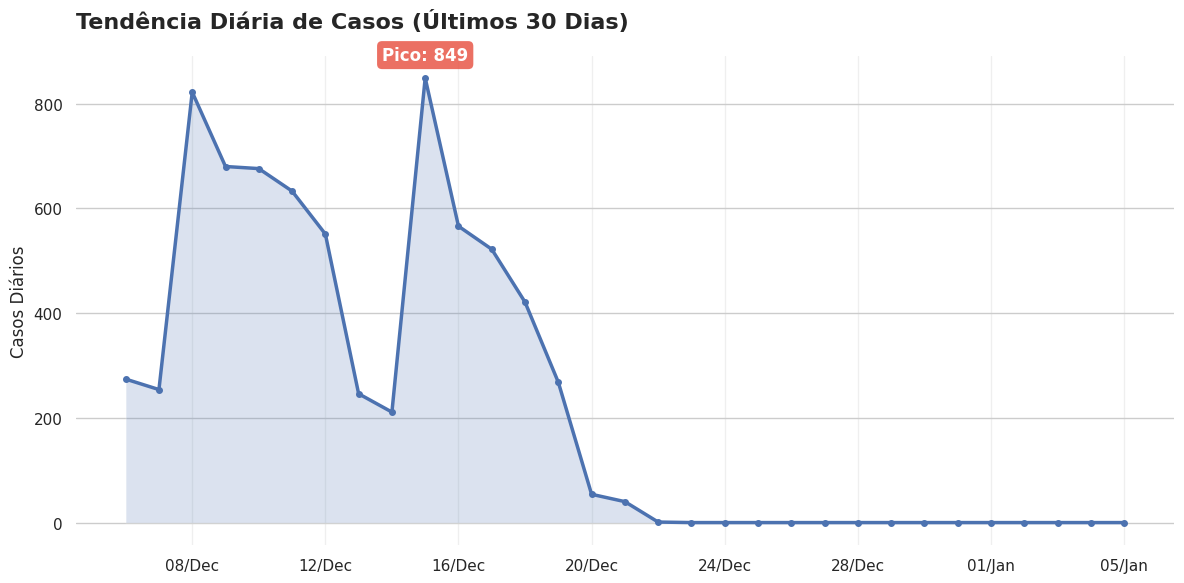

In [64]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plot_last_30d(df):
    df = df.copy()
    df["data_notificacao"] = pd.to_datetime(df["data_notificacao"], errors="coerce")

    ref_day = pd.Timestamp.today().normalize()
    start_day = ref_day - pd.Timedelta(days=30)

    df_30d = df[
        (df["data_notificacao"].notna()) &
        (df["data_notificacao"] >= start_day) &
        (df["data_notificacao"] <= ref_day)
    ]

    daily_cases = (
        df_30d
        .groupby(df_30d["data_notificacao"].dt.date)
        .size()
    )

    # --- MELHORIA CRÍTICA DE DADOS ---
    # Converte índice para Datetime e preenche dias vazios com 0
    # Isso evita que o gráfico "pule" dias que não tiveram casos
    full_idx = pd.date_range(start=start_day, end=ref_day, freq='D')
    daily_cases.index = pd.to_datetime(daily_cases.index)
    daily_cases = daily_cases.reindex(full_idx, fill_value=0)

    # --- ESTILIZAÇÃO ---
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plota a linha principal


    ax.plot(daily_cases.index, daily_cases.values, linewidth=2.5, marker='o', markersize=4)

    # Cria o efeito de área preenchida (Area Chart)
    ax.fill_between(daily_cases.index, daily_cases.values, alpha=0.2)

    # Títulos e Labels
    ax.set_title("Tendência Diária de Casos (Últimos 30 Dias)", fontsize=16, fontweight='bold', loc='left', pad=20)
    ax.set_xlabel("")
    ax.set_ylabel("Casos Diários", fontsize=12)

    # Formatação do Eixo X (Datas)
    # Intervalo de 4 dias para não poluir
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%b'))

    plt.xticks(rotation=0)

    # Limpeza visual
    sns.despine(left=True, bottom=True)
    ax.grid(axis='x', alpha=0.3) # Grid vertical mais leve

    # --- ANOTAÇÃO DE DESTAQUE ---
    max_val = daily_cases.max()
    if max_val > 0:
        max_date = daily_cases.idxmax()
        ax.annotate(f'Pico: {int(max_val)}',
                    xy=(max_date, max_val),
                    xytext=(0, 10),
                    textcoords='offset points',
                    ha='center', va='bottom',
                    bbox=dict(boxstyle="round,pad=0.3", fc="#e74c3c", ec="none", alpha=0.8),
                    color='white', fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_last_30d(df)

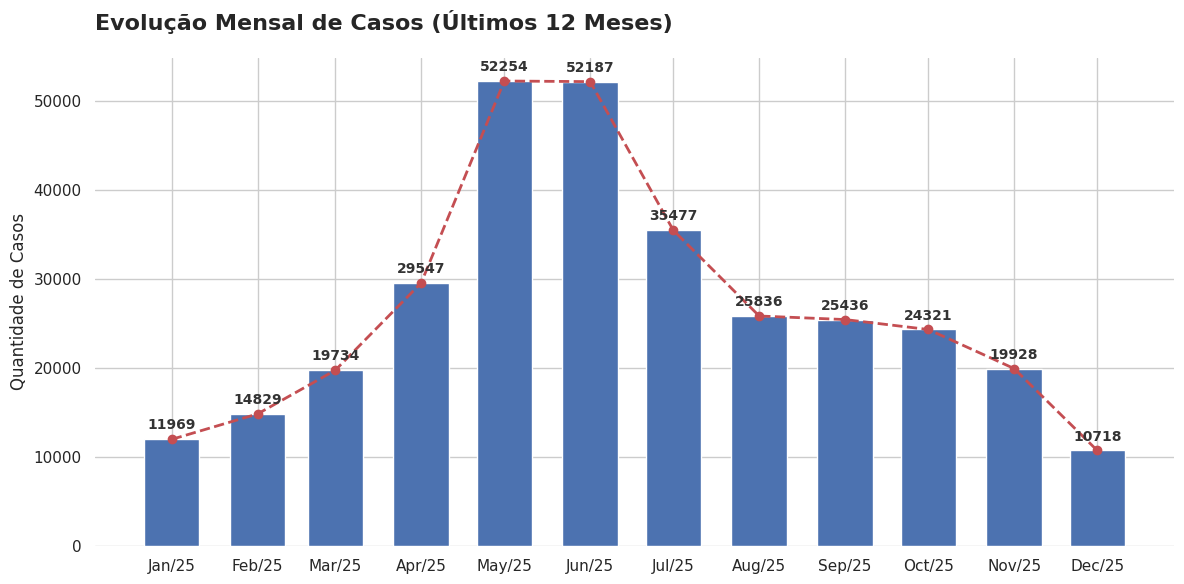

In [65]:
def plot_last_12m(df):
    df = df.copy()
    df["data_notificacao"] = pd.to_datetime(df["data_notificacao"], errors="coerce")

    ref_day = pd.Timestamp.today().normalize()
    start_day = ref_day - pd.DateOffset(months=12)

    df_12m = df[
        (df["data_notificacao"].notna()) &
        (df["data_notificacao"] >= start_day) &
        (df["data_notificacao"] <= ref_day)
    ]

    monthly_cases = (
        df_12m
        .groupby(df_12m["data_notificacao"].dt.to_period("M"))
        .size()
    )

    monthly_cases.index = monthly_cases.index.to_timestamp()

    # --- ESTILIZAÇÃO ---

    # Define um estilo clean (fundo branco com grid suave)
    sns.set_theme(style="whitegrid")

    # Cria a figura com tamanho maior (largura, altura)
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plota as barras
    bars = ax.bar(
        monthly_cases.index,
        monthly_cases.values,
        width=20,
        label='Casos'
    )

    # Adiciona uma linha de tendência suave por cima
    ax.plot(monthly_cases.index, monthly_cases.values, color='#c44e52', marker='o', linewidth=2, linestyle='--')

    # Títulos e Labels
    ax.set_title("Evolução Mensal de Casos (Últimos 12 Meses)", fontsize=16, fontweight='bold', pad=20, loc='left')
    ax.set_xlabel("") # Remove label "Mês" pois as datas já são óbvias
    ax.set_ylabel("Quantidade de Casos", fontsize=12)

    # Formatação do Eixo X (Datas)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y')) # Ex: Jan/24
    ax.xaxis.set_major_locator(mdates.MonthLocator()) # Garante um tick por mês
    plt.xticks(rotation=0) # Mantém reto se couber, ou 45 se ficar apertado

    # Remove bordas desnecessárias (topo e direita)
    sns.despine(left=True, bottom=True)

    # Adiciona os valores em cima de cada barra
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # 5 points de deslocamento vertical
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold', color='#333333')

    # Ajuste final e exibição
    plt.tight_layout()
    plt.show()

plot_last_12m(df)